In [1]:
from pylab import *  
import numpy as np

In [2]:
#--- precipitable water vapor (g/cm2)
uw = [0.0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5,2.75,3.0, 3.25, 3.5, 3.75, 4.0]

#--- surface skin temperature (K)
temps = [270, 275, 280, 285, 290, 295, 300]

#--- folder path
folder = 'figure/'

In [3]:
def read_sbdart_data(filename):
    f_raw = loadtxt(filename,delimiter="\t",skiprows=3,dtype='str')
    f = f_raw[::3]

    WL=[] #--- wavelength (um)
    FFV=[] #--- filter value
    TOPDN=[] #--- downwelling flux to the top of the atmosphere (TOA, W/cm2/um)
    TOPUP=[] #--- TOA upwelling flux
    TOPDIR=[] #--- TOA direct flux
    BOTDN=[] #--- downwelling flux at surface
    BOTUP=[] #--- upwelling flux at surface
    BOTDIR=[] #--- direct flux at surface

    for row in f:
        row = row[1:]
        row = row.replace('  ',' ')
        row = row.lstrip()
        split_row = row.split(' ')
        #print(split_row)
    
        WL.append(float(split_row[0]))
        FFV.append(float(split_row[1]))
        TOPDN.append(float(split_row[2]))
        TOPUP.append(float(split_row[3]))
        TOPDIR.append(float(split_row[4]))
        BOTDN.append(float(split_row[5]))
        BOTUP.append(float(split_row[6]))
        BOTDIR.append(float(split_row[7]))

    return TOPUP

In [4]:
flux_lw_290 = read_sbdart_data(folder+'11um_290')
flux_sw_290 = read_sbdart_data(folder+'39um_290')

In [5]:
flux_lw_290

[25.58,
 25.543,
 25.445,
 25.316,
 25.16,
 24.979,
 24.778,
 24.559,
 24.327,
 24.084,
 23.834,
 23.579,
 23.322,
 23.064,
 22.808,
 22.553,
 22.303]

In [6]:
flux_sw_290

[1.1994,
 1.1995,
 1.1953,
 1.1912,
 1.1873,
 1.1835,
 1.1796,
 1.1758,
 1.172,
 1.1681,
 1.1643,
 1.1604,
 1.1566,
 1.1527,
 1.1488,
 1.1448,
 1.1409]

#### Calculate the brightness temperature difference: 

* sbdart gives the flux density in w/m2/micron
* this can be easily converted to brightness temperature ($T_B$) with an inversion of Planck's equation: 
    * $\lambda$: wavelength
    * $\Omega$: beam solid angle
    * $S$: flux density
 
$$
T_b = \frac{c_2}{\lambda \text{ ln}(\frac{c_1}{\lambda^5 S}+1)}
$$

In [7]:
c = 2.99792458e8 #m/s
h = 6.6260755e-34 #Js
k = 1.380658e-23 #J/K

c1 = 2e24*h*c*c
print('c1:', c1)
c2 = 1e6*h*c/k
print('c2:', c2)

c1: 119104393.40652297
c2: 14387.68660333391


In [8]:
wl = 11 #micron
S = 9.5734294 #W/m^2/sr/micron
T_b = c2 / (wl * np.log(c1/((wl**5) * S) + 1) )
print('T_b:', T_b)

T_b: 300.00000005078795


In [9]:
def flux_to_Tb(flux, wl):
    #--- Original constants used
    #c1 = 3.74e-22
    #c2 = 0.0144
    S = np.array(flux)/(np.pi) #W m-2 um-1
    
    T_b = c2/(wl*np.log(c1/((wl**5)*S)+1))
    
    return T_b

In [10]:
S = 9.5734294*np.pi #W/m^2/sr/micron
T_b = flux_to_Tb(S, 11)
print('T_b:', T_b)

T_b: 300.00000005078795


In [11]:
S = np.array(flux_sw_290) #W/m^2/sr/micron
T_b = flux_to_Tb(S, 3.9)
print('T_b:', T_b)

T_b: [289.26482804 289.26671901 289.18718363 289.10931431 289.03503347
 288.96245909 288.88777022 288.81479586 288.74162231 288.66631477
 288.59273391 288.51700576 288.44301256 288.36685861 288.29048696
 288.2119295  288.13511267]


In [12]:
data = {}

for t in temps:
    flux_lw = read_sbdart_data(folder+'11um_'+str(t))
    flux_sw = read_sbdart_data(folder+'39um_'+str(t))
    
    
    BTD = flux_to_Tb(flux_lw, 11) - flux_to_Tb(flux_sw, 3.9)

    for i in range(len(uw)):
        data[t, uw[i]] = BTD[i]

data

{(270, 0.0): -0.47796083006056733,
 (270, 0.25): -0.17008704175515277,
 (270, 0.5): -0.02652351142336329,
 (270, 0.75): 0.1798576255987996,
 (270, 1.0): 0.4395842309054956,
 (270, 1.25): 0.731363584891028,
 (270, 1.5): 1.0392754623415499,
 (270, 1.75): 1.3484314325207265,
 (270, 2.0): 1.6445748579451447,
 (270, 2.25): 1.9216219513319288,
 (270, 2.5): 2.165238752450591,
 (270, 2.75): 2.373641432040756,
 (270, 3.0): 2.5401636100818905,
 (270, 3.25): 2.666290706144707,
 (270, 3.5): 2.751478492431829,
 (270, 3.75): 2.7963114982669026,
 (270, 4.0): 2.8013175411073234,
 (275, 0.0): -0.21082298237712394,
 (275, 0.25): -0.060522712250531185,
 (275, 0.5): 0.008498913201151481,
 (275, 0.75): 0.10524255970898366,
 (275, 1.0): 0.2182445494383387,
 (275, 1.25): 0.3395909687590688,
 (275, 1.5): 0.4604161164277798,
 (275, 1.75): 0.5722358542016082,
 (275, 2.0): 0.6669419747910297,
 (275, 2.25): 0.7389502864491533,
 (275, 2.5): 0.7823537848830142,
 (275, 2.75): 0.7975399890594872,
 (275, 3.0): 0.78172

In [13]:
x_values, y_values, values = zip(*[(x, y, value) for (x, y), value in data.items()])

In [14]:
btd_grid = np.array(values).reshape(len(temps), len(uw))
uw_grid, temp_grid = np.meshgrid(uw, temps)

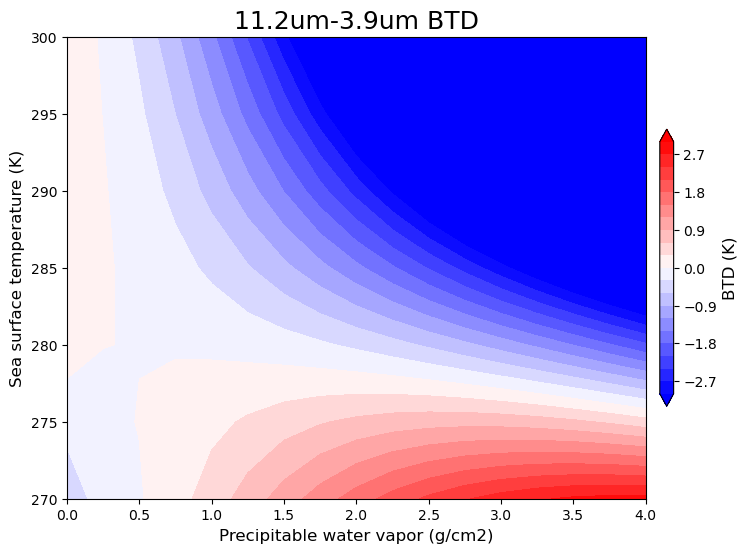

In [17]:
fig,ax=plt.subplots(1, figsize=(9,6))
cmap = plt.cm.bwr
levels = np.linspace(-3, 3, 21)

c=ax.contourf(uw_grid, temp_grid, btd_grid, cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.6, pad=0.02, ax=ax)
ax.set_title('11.2um-3.9um BTD', fontsize=18)
ax.set_ylabel('Sea surface temperature (K)', fontsize=12)
ax.set_xlabel('Precipitable water vapor (g/cm2)', fontsize=12)
clb.set_label('BTD (K)', fontsize=12)
plt.savefig('sbdart_sst_wv.png', dpi=200, bbox_inches='tight')

Comparing brightness temperature in a dry atmosphere: 

In [16]:
S_sw = np.array(flux_sw_290) #W/m^2/sr/micron
T_b_sw = flux_to_Tb(S_sw, 3.9)
print('T_b (3.9um, 290 K, no moisture):', T_b_sw[0])

S_lw = np.array(flux_lw_290) #W/m^2/sr/micron
T_b_lw = flux_to_Tb(S_lw, 11)
print('T_b (3.9um, 290 K, no moisture):', T_b_lw[0])

T_b (3.9um, 290 K, no moisture): 289.2648280410971
T_b (3.9um, 290 K, no moisture): 289.38040885233187
